In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

dat_folder = '/nrs/ahrens/Ziqiang/Takashi_DRN_project/ProcessedData/'
vol_file = '../Voltron_data/Voltron_Log_DRN_Exp.csv'
dat_xls_file = pd.read_csv(vol_file, index_col=0)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')
ablt_len = 6

def search_paired_data(row, flist):
    if 'before' not in row['fish']:
        return False
    fish = row['fish'][:-6]
    for _, row_ in flist.iterrows():
        if row_['folder'] != row['folder']:
            continue
        if row_['fish'] == fish+'after':
            return True
    return False

def align_components(row, check_shift=False, ablt_len=1, ablt_sovo_str_alt=''):
    from fish_proc.imageRegistration.imTrans import ImAffine
    trans = ImAffine()
    trans.level_iters = [1000, 1000, 100]
    trans.ss_sigma_factor = 1.0
    trans.verbosity = 0
    folder = row['folder']
    fish = row['fish'][:-ablt_len]
    save_fix = dat_folder + f'{folder}/{fish}before{ablt_sovo_str_alt}/Data'
    save_mov = dat_folder + f'{folder}/{fish}after{ablt_sovo_str_alt}/Data'
    fix_ = np.load(save_fix + '/motion_fix_.npy').astype('float32')
    move_ = np.load(save_mov + '/motion_fix_.npy').astype('float32')
    trans_affine = trans.estimate_translation2d(fix_, move_)
    trans_mat = trans_affine.affine
    x, y = trans_mat[0, 2], trans_mat[1, 2]
    x = int(round(x))
    y = int(round(y))
    if check_shift:
        if x>0:
            fix_ = fix_[:-x, :]
            move_ = move_[x:, :]
        else:
            fix_ = fix_[-x:, :]
            move_ = move_[:x, :]
        if y>0:
            fix_ = fix_[:, :-y]
            move_ = move_[:, y:]
        else:
            fix_ = fix_[:, -y:]
            move_ = move_[:, :y]
        plt.imshow(fix_, cmap=plt.cm.Greens)
        plt.imshow(move_, cmap=plt.cm.Reds, alpha=0.5)
        plt.title(folder+fish)
        plt.show()
    return x, y

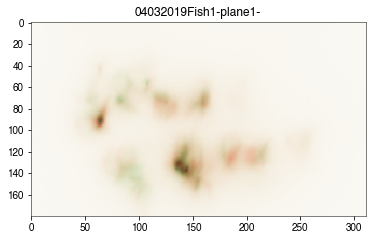

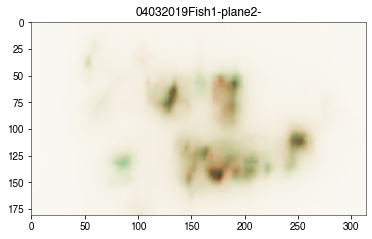

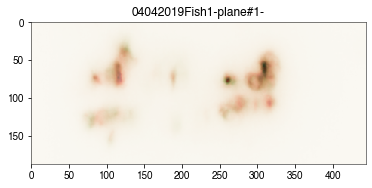

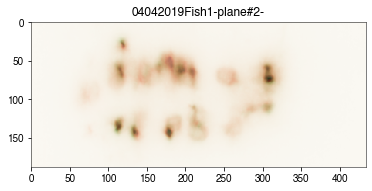

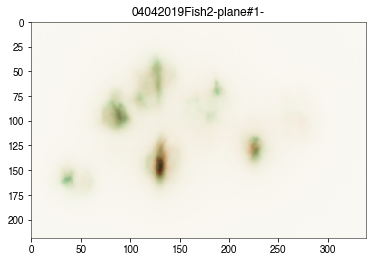

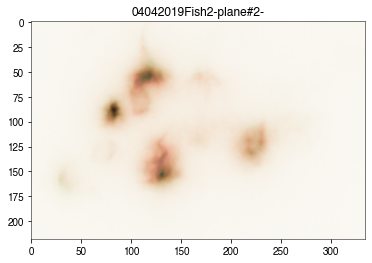

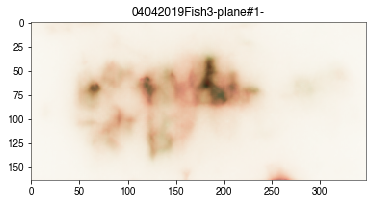

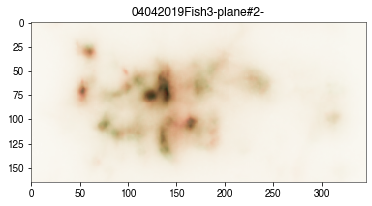

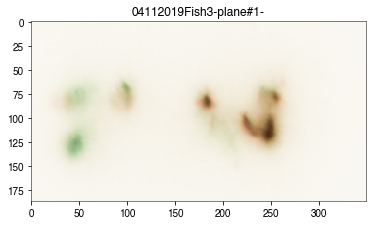

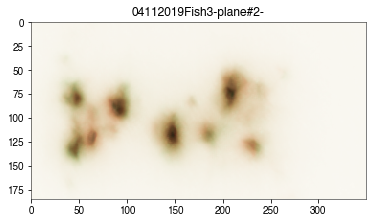

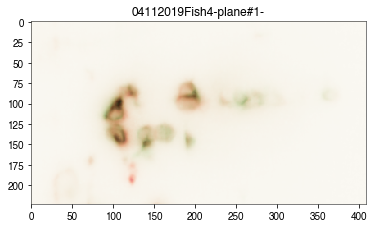

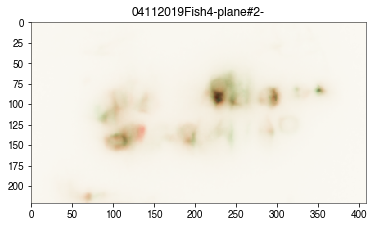

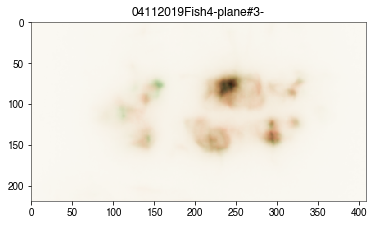

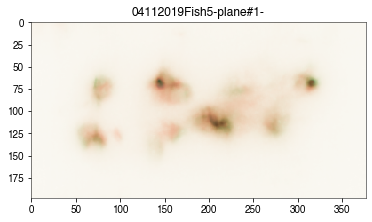

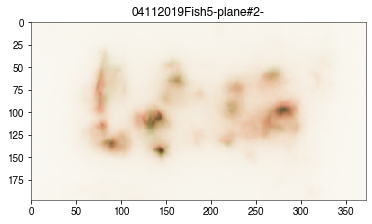

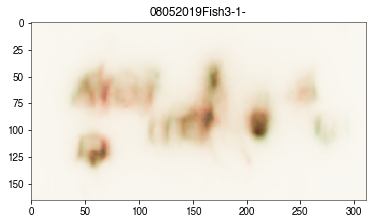

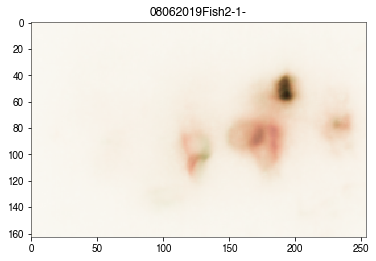

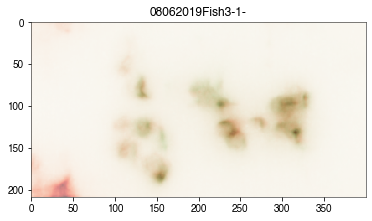

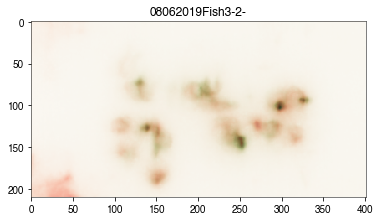

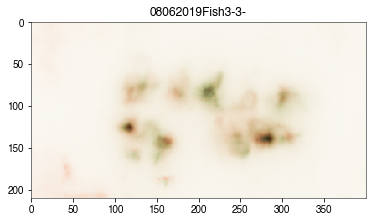

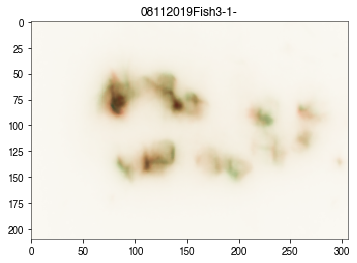

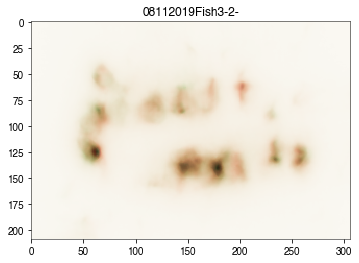

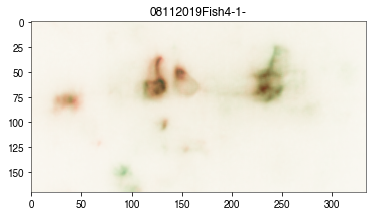

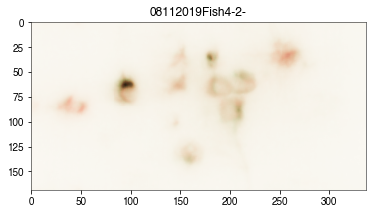

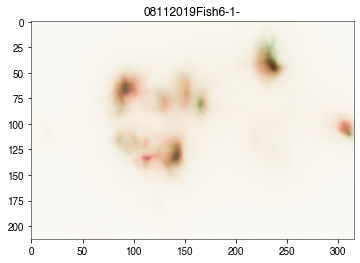

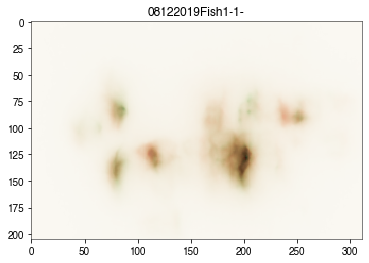

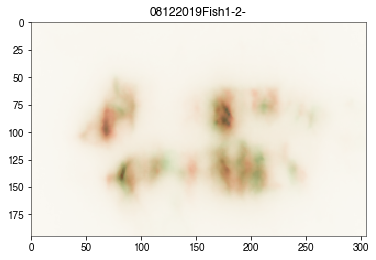

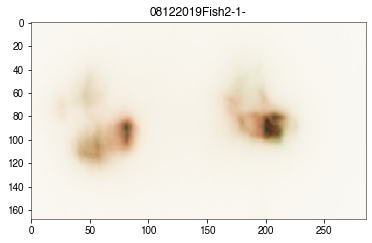

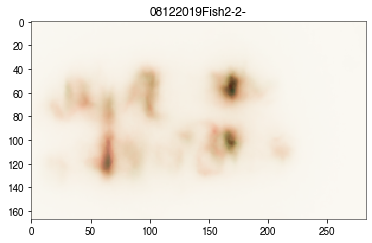

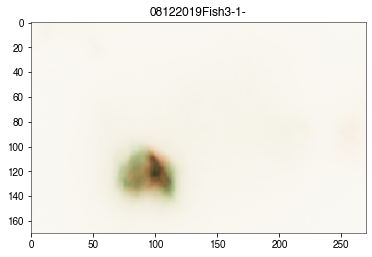

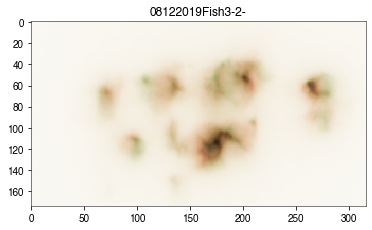

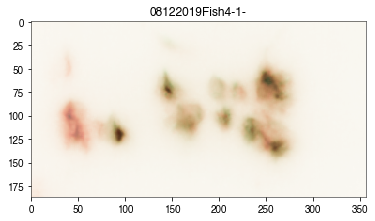

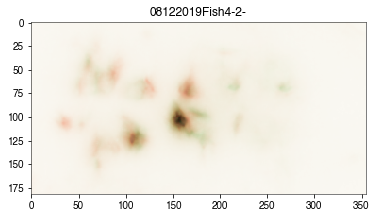

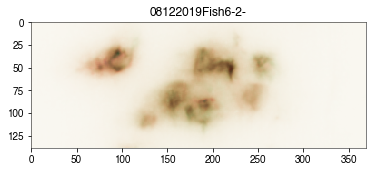

In [2]:
for _, row in dat_xls_file.iterrows():
    if search_paired_data(row, dat_xls_file):
        align_components(row, check_shift=True, ablt_len=ablt_len)